<a href="https://colab.research.google.com/github/K02D/Interpretable_HPO/blob/main/HPO_Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [ ]:
# Read data from NMT models trained on an English-to-Japanese corpus
hyp_data = pd.read_csv('en-ja.hyps_scaled', delimiter="\t")
eval_data = pd.read_csv('en-ja.evals', delimiter="\t")

In [ ]:
# Select scaled hyperparameter configurations as the input features
X = hyp_data

# Select first column of evaluation data, having dev_bleu values, as the target
y = eval_data[eval_data.columns[0]]

In [ ]:
# Check if number of rows is the same in target and input data
print(X)
print(y)

In [ ]:
# Split randomly into training and validation sets: 80% training, 20% validation 
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2) 

In [ ]:
# Fit multiple linear regression model on training data
reg = linear_model.LinearRegression()
reg.fit(train_X, train_y)

# Generate predictions on validation input data
pred_y = reg.predict(val_X) 

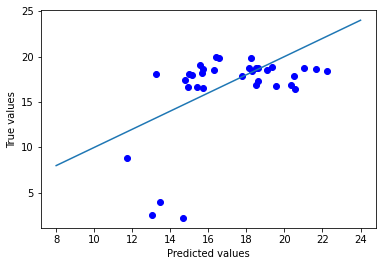

In [ ]:
 # Plot model predicted values (x-axis) against ground truth values (y-axis)
plt.scatter(pred_y, val_y, color ='b')

# Plot line y = x 
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x) 
    plt.plot(x, y)  
graph(lambda x: x, range(8, 25))

plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

The graph does NOT show the linear model that was fitted; rather, it provides a 
visualization of how close the predicted *dev_bleu* values are to the actual *dev_bleu* values.
The closer the points to the plotted line y=x, the better the model.

In [ ]:
mse = metrics.mean_squared_error(val_y, pred_y)
rmse = metrics.mean_squared_error(val_y, pred_y, squared=False)
mae = metrics.mean_absolute_error(val_y, pred_y)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 16.256930138128826
Root Mean Squared Error: 4.031988360366238
Mean Absolute Error: 2.919944822080153


In [ ]:
# Display weights learned by the model
hyps = ["bpe_symbols", "num_layers", "num_embed", "transformer_feed_forward_num_hidden", 
        "transformer_attention_heads", "initial_learning_rate"]
for hyp, w in zip(hyps, reg.coef_):
  print(f"{hyp}: {w}")

bpe_symbols: -0.9194372071242507
num_layers: 0.9660774641727214
num_embed: -5.567224028777085
transformer_feed_forward_num_hidden: 0.6001064513132677
transformer_attention_heads: -0.7266737963222618
initial_learning_rate: -5.3943864197813465


In [ ]:
# Develop a more accurate gradient boosting model
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4, random_state=1)
model.fit(train_X, train_y)

xgb_pred_y = model.predict(val_X)

In [ ]:
mse = metrics.mean_squared_error(val_y, xgb_pred_y)
mse

6.215114447848672

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = hyps)

Weight,Feature
1.1433 ± 0.5127,num_embed
0.9679 ± 0.5592,initial_learning_rate
0.3418 ± 0.4232,num_layers
0.1643 ± 0.1647,bpe_symbols
0.0748 ± 0.0853,transformer_attention_heads
-0.0361 ± 0.0460,transformer_feed_forward_num_hidden


(Sorry about the poor color contrast)

As the table shows, the features are ranked in the same order as that given by the weights in the linear model.